need to start with a good intuitive understanding of what a derivative is

In [119]:
# the copy paste imports that andrej kaparthy has in every
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline #th hek is this? https://stackoverflow.com/questions/43027980/purpose-of-matplotlib-inline

UsageError: unrecognized arguments: #th hek is this? https://stackoverflow.com/questions/43027980/purpose-of-matplotlib-inline


In [120]:
def f(x):
    return 4.20*x**2 + x + 6.9

f(42)

7457.7

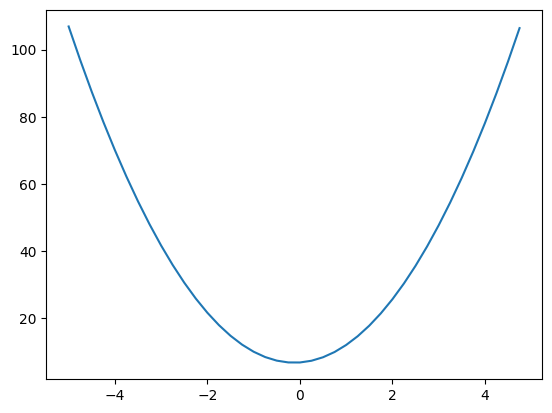

In [121]:
xs = np.arange(-5,5,0.25) # generates array from [-5,5) (not including 5) in steps of 0.25
ys = f(xs)
plt.plot(xs,ys)

### what is a derivative
if i slightly nudge x (in a pos direction), how does that change y? In which direction any by how much?

In [122]:
# here h represents a small nudge in a positive direction
h = 0.00000001
# with a smaller h we can more closley aproximate the slope
# but we have to be carful how small otherwise we get into trouble representing small numbers
x = 0.69
slope = (f(x + h) - f(x))/h
slope

6.7960000293965095

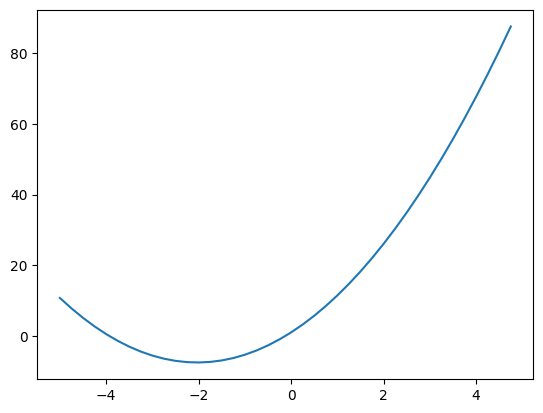

In [123]:
# playing with it a bit
def g(x):
    return 0.69*x**3 + 4.20*x**2 + x + 6.9

xp = np.arange(-5,5,0.25)
dydx = lambda f, x, h : (f(x + h) - f(x))/h
def df(x):
    return dydx(g, x, 0.00000001)

yp = df(xp)
plt.plot(xp,yp)

In [124]:
# getting a bit more complicated, andrej K example
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
# think of this as 3 inputs (a, b, c) into an expression graph with output d

# think through the derivative of d with respect to a, b, then c, and what the derivative is telling us

In [125]:
# wrt a
h = 0.0000001
# inputs
a = 2.0
b = -3.0
c = 10.0

def d(a):
    return a*b + c
d1 = d(a)
d2 = d(a+h)
slope = (d2-d1)/h
# the output of this should just be the value of b
# as d/da(a*b + c) = b
slope

-2.9999999995311555

In [142]:


class Value:
    # this is the core object of micrograd
    # What is the connective tissue for these object?
    # how do we keep pointers for these 'expression graphs'?

    def __init__(self, data, _children=(), _op='', label=''):
        """
        _children : will keep track of the graph
        _op : tracks which operation was used on the inputs to this Value, to procuce this Value
        
        """
        self.data = data
        # andrej explains that in his original micrograd code
        # he takes in a tuple and makes it a set, prob some performace reason
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None # function that does a little piece of chain rule


    def __repr__(self):
        return f"Value(data={self.data})"

    # by default python wont know how to add two Value objects together
    # so we have to define it with __add__
    def __add__(self, other):
        # problem: if we try to do somthing like a + 1, as 1 is an int and not a value
        other = other if isinstance(other, Value) else Value(other)

        # how do we handle if self and other ref to the same symbol?
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            # store how to change the output gradients into the inputs gradient
            # by using += we can accumilate 
            # so in a = b + b
            # the first b will "deposit" one and the second b will deposit one to get da/db = 2*...
            self.grad += out.grad * 1.0
            other.grad += out.grad * 1.0
            
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        out.grad = other.data # ??
        def _backward():
            # have: out = self*other, want dL/dself, dL/dother
            # self.grad = dL/dself =  dL/dOut * dout/dSelf
            # do/ds = o
            # dL/dS = dL/dO * O
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
            return
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers atm"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += out.grad * other * self.data**(other-1) #exercize


        out._backward = _backward

        return out
    
    # need this for 2*a cases as int.__mul__(Value) is not defined, so python will try __rmul__
    def __rmul__(self, other): # other * self
        return self * other
    # after defining exp, AK explains that division is actually a special case
    # a / b = a * (1/b) = a * (b**-1)
    # we want to be able to differentiate x**k for some k for some constant k, int of float
    # this is more general so might as well do it this way 
    def __truediv__(self, other):
        return self * other ** -1
    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def tanh(self):
        # scope how tanh is defined on wiki
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), label='tanh')
        def _backward():
            # we have out.grad and we want to chain it into self.grad
            self.grad += (1 - t**2) * out.grad
            return
            
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,),'exp')
    
        def _backward():
            self.grad = out.grad * out.data
        
        out._backward = _backward

        return out
    

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
            return
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [127]:
from graphviz import Digraph
# copy pasta code
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

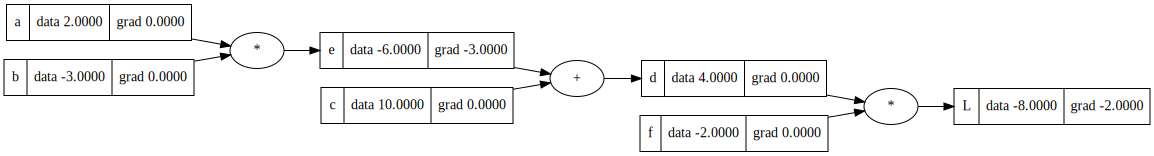

In [128]:
draw_dot(L)

L = d * f
dL/dd = f

(f(x+h)-f(x))/h
f = L
((d+h)f - d*f)/h
as h -> 0
(df - df + hf ) / h = h*f/h = f


In [129]:
# setting these manually
L.grad = 1
f.grad = 4.0
d.grad = -2

### The crux of backprop, 
if we understand the gradient at a node then we unserstand everything?
consider the path in the function graph from c -> d -> L.
how do we figure out how a small change in c affects L?
Say we know already know how d affects L, and how c affects d.
With this information we should be able to peice together how c affets L.

dd/dc ? 1  
d = c+e   
so   
dd/dc = 1.0 (treat e as constant and d/dc(c) = 1 )  
similarly:  
dd/de = 1.0  
#### Chain rule 
Leibniz notation:  
if z depends on y, and y depends on x.  
then z depends on x as well.  
via y we can express the chain rule as:  
dz/dx = dz/dy * dy/dx,  
and  
(dz/dx)|x = (dz/dy)|y(x) * (dy/dx)|x,   
"if a car travels twice as fast as a bicyle and the bicycle is four times as fast as a walking man,  
 then the car travels 2 x 4 = 8 times as fast as the man"


##### in our case
we know dL/dd and dd/dc  
we WANT: dL/dd  
so:  
dL/dc = dL/dd * dd/dc

In [130]:
# calculating dL/dc and dL/de manually
# d = c + e
# dd/dc = 1
# dL/dc = dL/dd * dd/dc = (-2) *  1 = -2
# dL/de = dL/dd * dd/de = dL/dd * 1 = -2
c.grad = -2
e.grad = -2
# going to the next layer, we want dL/da and dL/db
# e = ab
# since a -> e -> d -> L: ...
# dL/da = dL/dd * dd/de * de/da 
# but its easier if we just use:
# dL/da = dL/de * de/da
# because the node we are on knows dL/de
# de/da = b
# so
# dL/da = dL/de * b.data = -2 * -3 = 6
a.grad = -2.0 * -3.0
# similarly
# dL/db = dL/de * a.data = -2 * 2 = -4
b.grad = -2.0 * 2.0 

In [131]:
def lol():
    # staging area for playing with manual back prop
    # use to verify manual backprop
    h = 0.001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    # add +h below with x.data += h where x is some variable
    # "numerical gradient check"
    # here we can add a +h to d to get dL/df
    # or add a +h to get dL/dd
    a = Value(2.0, label='a')
    #a.data += h
    b = Value(-3.0, label='b')
    #b.data += h
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    return ((L2 - L1)/h)

lol()

0.0

we can now build models with plus and minus op
scalar values,
we can do a forward pass and build a mathematical expresion and visualize that

NEXT we want to run backprop, 
we will start at the end and go in reverse to compute the derivative of that node with respect to L

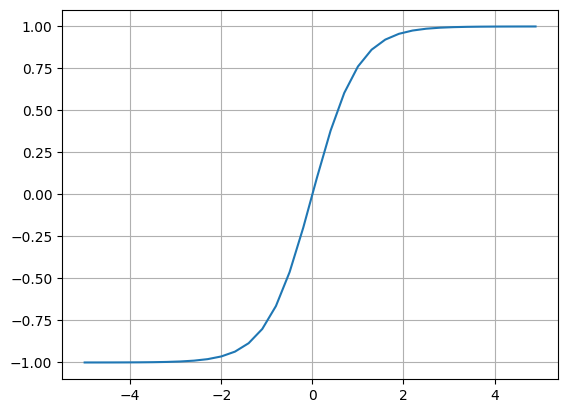

In [132]:
xs = np.arange(-5,5,0.3)
plt.plot(xs, np.tanh(xs)); plt.grid(); 

In [143]:
# neuron example with bias
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')
#...
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o' #tanh needs to be implemented in Value

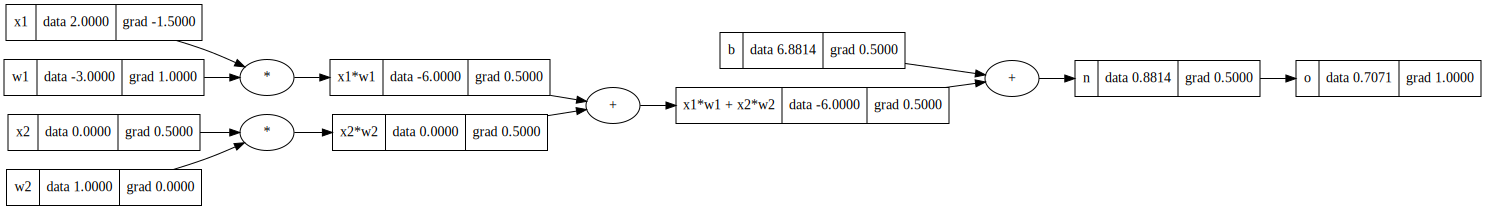

In [145]:
#o.backward()
draw_dot(o)

In [140]:
o.grad = 1 # init the base case, otherwize this will be 0
# conviniently 
# do/dn = 1 - tanh(n) ** 2 = 1 - o**2

# andrej continues to do above calc manually 
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
    return
build_topo(o)
for node in reversed(topo):
    node._backward()

In [136]:
n._backward()



In [137]:
b._backward() # b does is empty function because it is a leaf node
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
b.grad, x1w1x2w2.grad, x1w1.grad, x2w2.grad

(0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999,
 0.4999999999999999)

In [ ]:
# fixing backprop bug when one node is used multiple times
# ie b = a+a
